# Library

In [1]:
# Standard Library Imports
import json     
import os        
import sys       
import time   
import ast  
import shutil
import warnings
import copy

# Deep Learning & Addestramento
import torch    
import torchvision  
from pathlib import Path
from torch import nn  
from torch.utils.data import Dataset 

# Librerie per Visualizzazione
import matplotlib.pyplot as plt  
import matplotlib.patches as patches  
import seaborn as sns 
import numpy as np 

# Librerie per Metriche & Valutazione
from sklearn.metrics import precision_recall_curve, confusion_matrix  

# Utilità Generali
from tqdm import tqdm  
from pprint import PrettyPrinter  
import random 
from collections import defaultdict, Counter
from PIL import Image  
import xml.etree.ElementTree as ET 
import torchvision.transforms.functional as FT 

## Path

In [2]:
COCO_JSON_NM = 'COCO_annotations_new.json' 
OUT_COCO_JSON_NM = 'mod_COCO_annotations_new.json'
OUT_IMAGE_FLDR_NM = 'images'

in_dataset_pth = Path('/kaggle/input/our-xview-dataset')
out_dataset_pth = Path('/kaggle/working/')
img_dict = Path(f'/kaggle/input/our-xview-dataset/{OUT_IMAGE_FLDR_NM}')

coco_json_path = in_dataset_pth / COCO_JSON_NM
new_coco_json_path = out_dataset_pth / OUT_COCO_JSON_NM


# path file per il training
train_image = os.path.join(out_dataset_pth, 'TRAIN_images.json')
train_bbox = os.path.join(out_dataset_pth, 'TRAIN_objects.json')

# path file per la validation
val_image = os.path.join(out_dataset_pth, 'VAL_images.json')
val_bbox = os.path.join(out_dataset_pth, 'VAL_objects.json')

# path file per il test
test_image = os.path.join(out_dataset_pth, 'TEST_images.json')
test_bbox = os.path.join(out_dataset_pth, 'TEST_objects.json')

# Modello e CheckPoint predefinito
model_ssd_path = '/kaggle/input/ssd_checkpoint/pytorch/ssd/3'
checkpoint_path = '/kaggle/input/ssd_checkpoint/pytorch/ssd/3/checkpoint_ssd300.pth.tar'

RANDOM_SEED = 2023
random.seed(RANDOM_SEED)

In [3]:
# Pulizia dell'output per cartelle specifiche
def clean_output(output_dir):
    if output_dir.exists() and output_dir.is_dir():
        for item in output_dir.iterdir():
            if item.is_dir():
                shutil.rmtree(item)  # Rimuove la sotto-cartella
            else:
                item.unlink()  # Rimuove il file
        print(f"Cartella {output_dir} pulita.")
    else:
        print(f"Cartella {output_dir} non trovata. Nessuna azione necessaria.")

# Pulisce la cartella di output prima di avviare il processo
clean_output(out_dataset_pth)

Cartella /kaggle/working pulita.


In [4]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", message=".*SourceChangeWarning.*")

# Utility

In [5]:
def load_json(file_path):
    """
    Carica un file JSON dal percorso specificato.

    :param file_path: Percorso al file JSON da caricare.
    :return: Dati contenuti nel file JSON (come dizionario o lista).
    """
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

In [6]:
def random_filename(json_path):
    data = load_json(json_path)
    filenames = {img['file_name'] for img in data.get("images", [])}
    
    # Convertire il set in una lista per evitare il DeprecationWarning
    random_filenames = random.sample(list(filenames), min(2, len(filenames)))
    return random_filenames

In [7]:
def display_images_with_bboxes(json_file, specific_images, images_folder, mode = 2):
    """
    Visualizza le immagini specificate con tutti i bounding box sopra di esse.

    :param json_file: percorso del file JSON contenente le immagini, annotazioni e categorie
    :param specific_images: lista di nomi delle immagini da visualizzare
    :param images_folder: percorso della cartella che contiene le immagini
    """
    # Carica il JSON
    with open(json_file, 'r') as f:
        data = json.load(f)

    # Estrai le immagini e le annotazioni
    images = data["images"]
    annotations = data["annotations"]

    # Crea un dizionario per mappare l'id delle immagini al nome del file
    image_dict = {image["id"]: image["file_name"] for image in images}

    # Filtra le annotazioni per le immagini specifiche
    specific_annotations = [ann for ann in annotations if image_dict[ann["image_id"]] in specific_images]

    # Creiamo un dizionario per raccogliere tutte le annotazioni per ciascuna immagine
    image_bboxes = {}
    for annotation in specific_annotations:
        image_name = image_dict[annotation["image_id"]]
        if image_name not in image_bboxes:
            image_bboxes[image_name] = []
        if mode == 1:
            bbox = ast.literal_eval(annotation["bbox"])
        else:
            bbox = annotation["bbox"]
        category_id = annotation["category_id"]
        image_bboxes[image_name].append((bbox, category_id))

    # Visualizza tutte le immagini con tutti i bounding box
    for image_name, bboxes in image_bboxes.items():
        # Carica l'immagine
        image_path = f'{images_folder}/{image_name}'  # Usa il percorso corretto per le immagini
        image = Image.open(image_path)

        # Crea la figura per la visualizzazione
        plt.figure(figsize=(8, 8))
        plt.imshow(image)

        # Aggiungi tutti i bounding box e il category_id
        if mode == 1:
            for bbox, category_id in bboxes:
                x, y, w, h = bbox
                plt.gca().add_patch(plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none'))
                plt.text(x, y - 5, f'Category: {category_id}', color='red', fontsize=10, backgroundcolor='white')
        else:
            for bbox, category_id in bboxes:
                x, y, x2, y2 = bbox
                w = x2 - x
                h = y2 - y
                plt.gca().add_patch(plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none'))
                plt.text(x, y - 5, f'Category: {category_id}', color='red', fontsize=10, backgroundcolor='white')

        # Imposta il titolo e disattiva gli assi
        plt.title(f"Image: {image_name}")
        plt.axis('off')
        plt.show()

In [8]:
def plot_category_distribution(json_path):
    # Carica il JSON
    with open(json_path, 'r') as file:
        data = json.load(file)
    
    # Estrai le annotazioni
    annotations = data['annotations']
    
    # Conta le occorrenze delle categorie
    category_counts = Counter(item['category_id'] for item in annotations)
    
    # Prepara i dati per il grafico
    categories = list(category_counts.keys())
    counts = list(category_counts.values())
    
    # Crea il grafico
    plt.figure(figsize=(10, 6))
    plt.bar(categories, counts, color='skyblue')
    plt.xlabel('Category ID')
    plt.ylabel('Frequency')
    plt.title('Distribuzione delle categorie nel dataset')
    plt.xticks(categories)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [9]:
def extract_categories_from_custom_coco_json(json_path):
    """
    Estrae i nomi delle categorie da un file JSON COCO personalizzato, ordinati per ID.

    Args:
        json_path (str): Path del file JSON COCO personalizzato.

    Returns:
        list: Lista di nomi delle categorie ordinate per ID.
    """
    # Leggi il file JSON
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # Ottieni le categorie dal JSON
    raw_categories = data.get('categories', [])
    
    # Crea una lista di categorie con id e nome
    categories = []
    for category in raw_categories:
        # Si assume che category sia un dizionario con "id" e "name"
        if isinstance(category, dict) and 'id' in category and 'name' in category:
            categories.append(category)
        else:
            print(f"Errore nel formato della categoria: {category}")
    
    # Ordina le categorie in base all'ID
    categories = sorted(categories, key=lambda cat: cat["id"])
    
    # Aggiungi la categoria "background" con ID 0 se non esiste
    if not any(cat['id'] == 0 for cat in categories):
        categories.insert(0, {"id": 0, "name": "background"})
    
    # Estrai solo i nomi delle categorie
    category_names = [cat["name"] for cat in categories]
    
    return category_names

# Test Dataset

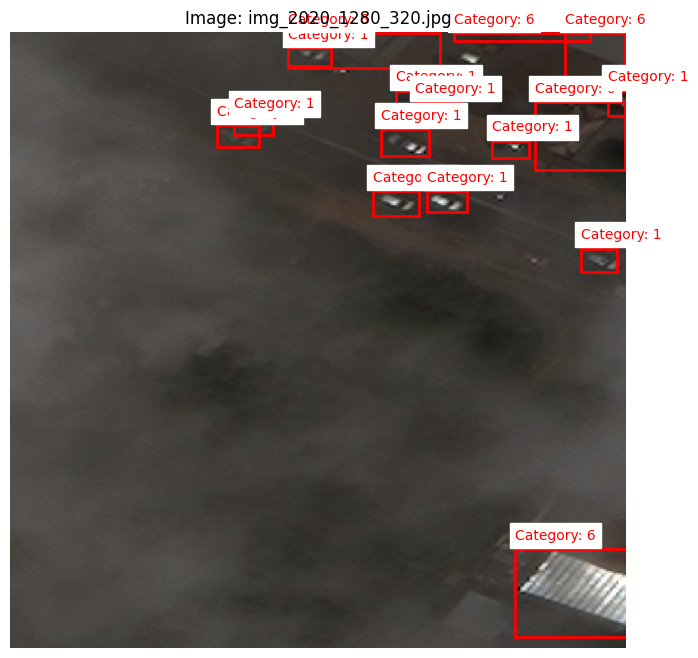

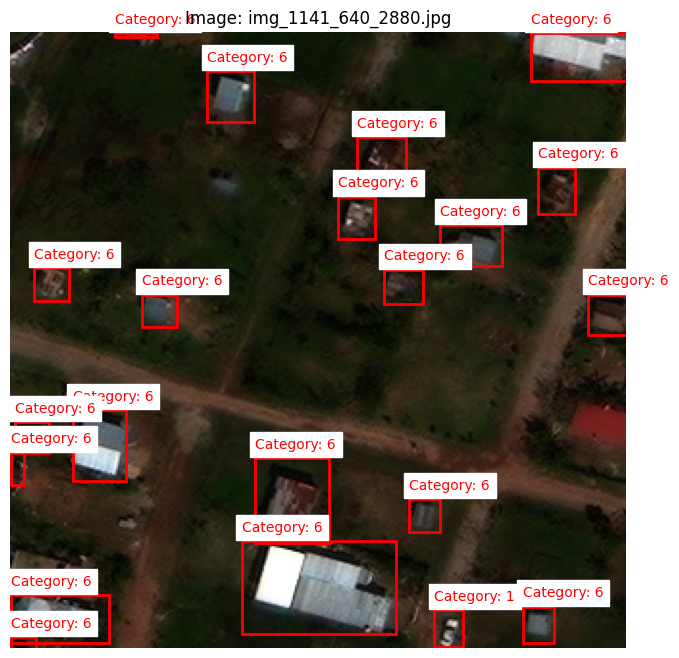

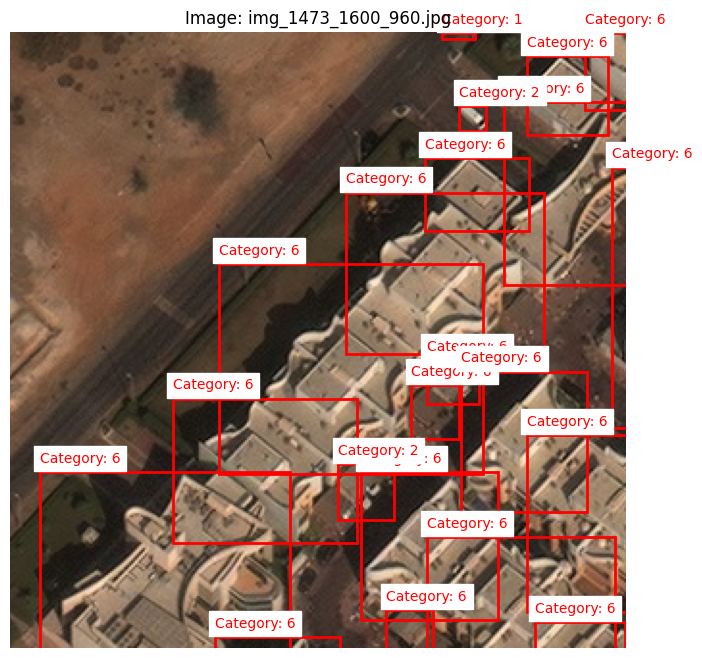

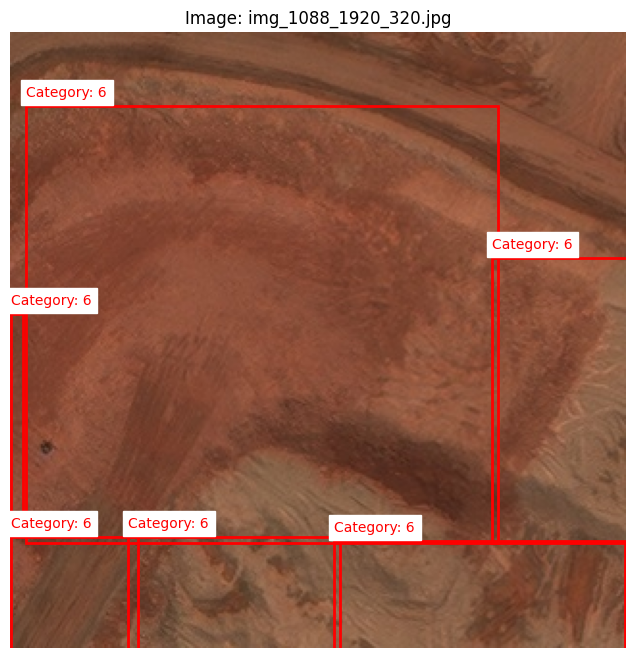

In [10]:
specific_images = ['img_2020_1280_320.jpg','img_1473_1600_960.jpg', 'img_1088_1920_320.jpg', 'img_1141_640_2880.jpg']

display_images_with_bboxes(coco_json_path, specific_images, img_dict, mode = 1)

# COCO Preprocessing

In [11]:
def process_custom_coco_json(input_path, output_path):
    """
    Funzione per processare un JSON COCO in formato personalizzato.
    """
    # Leggi il JSON dal file di input
    data = load_json(input_path)

    # Ottieni e correggi il formato delle categorie
    raw_categories = data.get('categories', [])
    categories = []
 
    for category in tqdm(raw_categories, desc="Processing Categories"):
        for id_str, name in category.items():
            try:
                categories.append({"id": int(id_str), "name": name})
            except ValueError:
                print(f"Errore nel parsing della categoria: {category}")
 
    # Trova la categoria "Aircraft" con ID 0
    aircraft_category = next((cat for cat in categories if cat['id'] == 0 and cat['name'] == "Aircraft"), None)
    if aircraft_category:
        aircraft_category['id'] = 11  # Cambia l'ID della categoria "Aircraft" a 11
 
    # Aggiungi la categoria "background" con ID 0 se non esiste
    if not any(cat['id'] == 0 for cat in categories):
        categories.append({"id": 0, "name": "background"})
 
    # Preprocessa le annotazioni in un dizionario per immagini
    image_annotations_dict = {}
    for annotation in tqdm(data.get('annotations', []), desc="Building Image Annotations Dictionary"):
        image_id = annotation['image_id']
        if image_id not in image_annotations_dict:
            image_annotations_dict[image_id] = []
        image_annotations_dict[image_id].append(annotation)
 
    # Elenco di annotazioni da mantenere (solo quelle valide)
    valid_annotations = []
    annotations_to_remove = set()
 
    # Controllo dei bounding box
    for annotation in tqdm(data.get('annotations', []), desc="Processing Annotations"):
        if annotation['category_id'] == 0:  # Se è Aircraft
            annotation['category_id'] = 11
        
        # Converte il formato del bbox
        if isinstance(annotation['bbox'], str):
            annotation['bbox'] = json.loads(annotation['bbox'])
        
        x, y, width, height = annotation['bbox']
        xmin, xmax = x, x + width
        ymin, ymax = y, y + height
        
        # Verifica che xmin < xmax e ymin < ymax, e che la larghezza e altezza siano sufficienti
        if xmin >= xmax or ymin >= ymax or width <= 10 or height <= 10:
            annotations_to_remove.add(annotation['id'])
        else:
            annotation['bbox'] = [xmin, ymin, xmax, ymax]
            valid_annotations.append(annotation)
 
    # Rimuovi le annotazioni non valide
    data['annotations'] = valid_annotations
 
    # Aggiorna le categorie nel JSON
    data['categories'] = categories

    # Seleziona casualmente il 20% delle immagini
    all_images = data.get('images', [])
    selected_images = random.sample(all_images, len(all_images) // 5)
    selected_image_ids = {img['id'] for img in selected_images}

    # Filtra immagini e annotazioni
    data['images'] = selected_images
    data['annotations'] = [ann for ann in data['annotations'] if ann['image_id'] in selected_image_ids]
 
    # Scrivi il JSON modificato nel file di output
    with open(output_path, 'w') as f:
        json.dump(data, f, indent=4)

In [12]:
process_custom_coco_json(coco_json_path, new_coco_json_path)

Processing Annotations: 100%|██████████| 669983/669983 [00:03<00:00, 211185.23it/s]


In [13]:
specific_images = ['img_2020_1280_320.jpg','img_1473_1600_960.jpg', 'img_2122_640_0.jpg', 'img_1141_640_2880.jpg']

display_images_with_bboxes(new_coco_json_path, specific_images, img_dict)

In [14]:
old_json = load_json(coco_json_path)

In [15]:
# Conta il numero di immagini, annotazioni e categorie
num_images = len(old_json.get("images", []))
num_annotations = len(old_json.get("annotations", []))
num_categories = len(old_json.get("categories", []))

print(f"Numero di immagini: {num_images}")
print(f"Numero di annotazioni: {num_annotations}")
print(f"Numero di categorie: {num_categories}")

Numero di immagini: 45891
Numero di annotazioni: 669983
Numero di categorie: 11


In [16]:
new_json = load_json(new_coco_json_path)

In [17]:
# Conta il numero di immagini, annotazioni e categorie
num_images = len(new_json.get("images", []))
num_annotations = len(new_json.get("annotations", []))
num_categories = len(new_json.get("categories", []))

print(f"Numero di immagini: {num_images}")
print(f"Numero di annotazioni: {num_annotations}")
print(f"Numero di categorie: {num_categories}")

Numero di immagini: 9178
Numero di annotazioni: 98108
Numero di categorie: 12


# Undersampling and Oversampling

In [18]:
def count_bboxes_per_category(json_path):
    """
    Funzione che conta il numero di bounding box per ciascuna categoria in un file JSON formato COCO.
    
    :param json_path: Percorso al file JSON.
    :return: Dizionario con i nomi delle categorie come chiavi e il conteggio dei bounding box come valori.
    """
    # Leggi il JSON dal file
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # Ottieni mapping delle categorie (id -> nome)
    category_mapping = {cat['id']: cat['name'] for cat in data.get('categories', [])}
    
    # Conta i bounding box per ciascun category_id
    bbox_counts = defaultdict(int)
    for annotation in data.get('annotations', []):
        category_id = annotation['category_id']
        bbox_counts[category_id] += 1
    
    # Converti il conteggio usando i nomi delle categorie
    bbox_counts_named = {category_mapping[cat_id]: count for cat_id, count in bbox_counts.items()}

    return bbox_counts_named

In [19]:
bbox_counts = count_bboxes_per_category(new_coco_json_path)

# Stampa i risultati
for category, count in bbox_counts.items():
    print(f"Categoria: {category}, Numero di bbox: {count}")

Categoria: Building, Numero di bbox: 68882
Categoria: Passenger Vehicle, Numero di bbox: 19615
Categoria: Engineering Vehicle, Numero di bbox: 883
Categoria: Truck, Numero di bbox: 4950
Categoria: Maritime Vessel, Numero di bbox: 1115
Categoria: Storage Tank, Numero di bbox: 431
Categoria: Pylon, Numero di bbox: 78
Categoria: Railway Vehicle, Numero di bbox: 722
Categoria: Shipping Container, Numero di bbox: 1112
Categoria: Aircraft, Numero di bbox: 287
Categoria: Helipad, Numero di bbox: 33


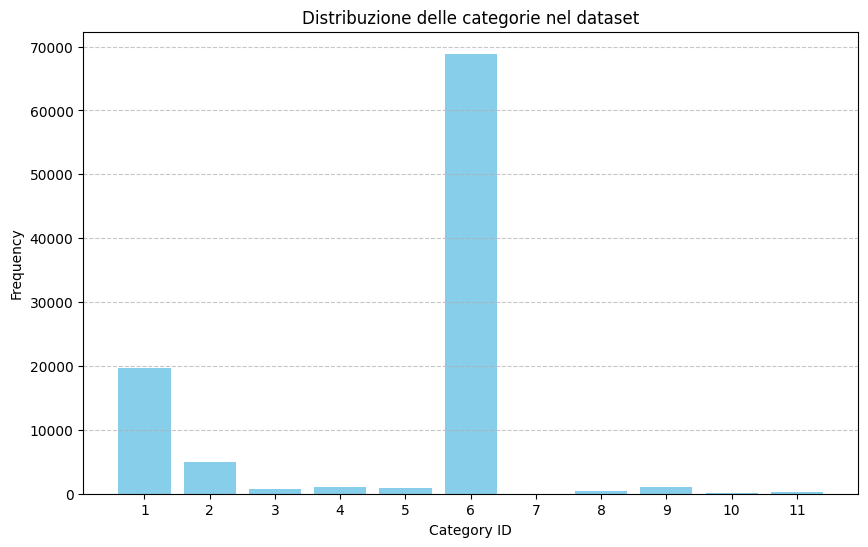

In [20]:
plot_category_distribution(new_coco_json_path)

In [21]:
def undersample_class(json_data_path, dataset_out, target_class=6):
    json_data = load_json(json_data_path)
    
    # Conta le occorrenze della classe target e delle altre classi per immagine
    image_class_counts = Counter()
    non_target_class_counts = Counter()
    for annotation in json_data["annotations"]:
        if annotation["category_id"] == target_class:
            image_class_counts[annotation["image_id"]] += 1
        else:
            non_target_class_counts[annotation["image_id"]] += 1

    # Rimuovi immagini che contengono solo la classe target
    images_with_only_target = {
        image_id for image_id in image_class_counts 
        if non_target_class_counts[image_id] == 0
    }

    # Filtra immagini e annotazioni per rimuovere quelle con solo la classe target
    remaining_images = [
        img for img in json_data["images"] 
        if img["id"] not in images_with_only_target
    ]
    remaining_annotations = [
        ann for ann in json_data["annotations"] 
        if ann["image_id"] not in images_with_only_target
    ]

    # Aggiorna il JSON
    json_data["images"] = remaining_images
    json_data["annotations"] = remaining_annotations

    # Salva il risultato in un nuovo file
    with open(dataset_out, "w") as file:
        json.dump(json_data, file, indent=4)

    print("Immagini processate e undersampling completato")

In [22]:
undersample_class(new_coco_json_path, new_coco_json_path, target_class=6)

Immagini processate e undersampling completato


In [23]:
bbox_counts = count_bboxes_per_category(new_coco_json_path)

# Stampa i risultati
for category, count in bbox_counts.items():
    print(f"Categoria: {category}, Numero di bbox: {count}")

Categoria: Building, Numero di bbox: 42067
Categoria: Passenger Vehicle, Numero di bbox: 19615
Categoria: Engineering Vehicle, Numero di bbox: 883
Categoria: Truck, Numero di bbox: 4950
Categoria: Maritime Vessel, Numero di bbox: 1115
Categoria: Storage Tank, Numero di bbox: 431
Categoria: Pylon, Numero di bbox: 78
Categoria: Railway Vehicle, Numero di bbox: 722
Categoria: Shipping Container, Numero di bbox: 1112
Categoria: Aircraft, Numero di bbox: 287
Categoria: Helipad, Numero di bbox: 33


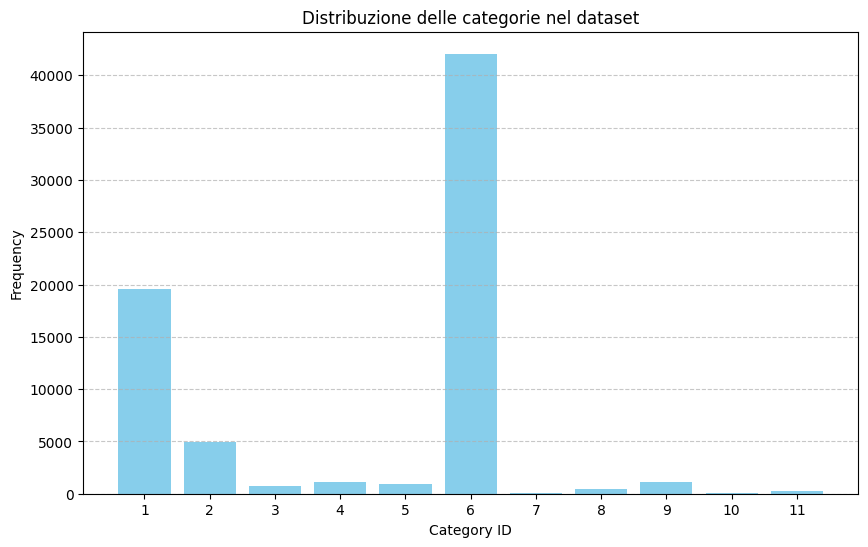

In [24]:
plot_category_distribution(new_coco_json_path)

In [25]:
def upsample_classes(json_data_path, dataset_out, classes_to_upsample, value):
    json_data = load_json(json_data_path)

    # Conta le occorrenze attuali per ciascuna classe
    class_bbox_counts = Counter()
    for annotation in json_data["annotations"]:
        if annotation["category_id"] in classes_to_upsample:
            class_bbox_counts[annotation["category_id"]] += 1

    # Filtra immagini con solo le classi target
    class_images = {class_id: [] for class_id in classes_to_upsample}
    for img in json_data["images"]:
        image_id = img["id"]
        img_annotations = [
            ann for ann in json_data["annotations"]
            if ann["image_id"] == image_id and ann["category_id"] in classes_to_upsample
        ]
        if all(ann["category_id"] in classes_to_upsample for ann in img_annotations):
            for ann in img_annotations:
                class_images[ann["category_id"]].append((img, ann))

    # Crea nuove annotazioni per raddoppiare le occorrenze
    new_images = []
    new_annotations = []
    image_id_offset = max(img["id"] for img in json_data["images"]) + 1
    annotation_id_offset = max(ann["id"] for ann in json_data["annotations"]) + 1

    for class_id in classes_to_upsample:
        class_data = class_images[class_id]
        idx = 0
        current_count = class_bbox_counts[class_id]

        # Raddoppia le annotazioni fino a raggiungere il doppio
        while current_count < value * class_bbox_counts[class_id]:
            img, ann = class_data[idx % len(class_data)]

            # Duplica l'immagine
            new_img = copy.deepcopy(img)
            new_img["id"] = image_id_offset

            # Duplica l'annotazione
            new_ann = copy.deepcopy(ann)
            new_ann["id"] = annotation_id_offset
            new_ann["image_id"] = image_id_offset

            new_images.append(new_img)
            new_annotations.append(new_ann)

            # Incrementa gli offset e il conteggio
            image_id_offset += 1
            annotation_id_offset += 1
            current_count += 1
            idx += 1

    # Aggiungi le nuove immagini e annotazioni al JSON
    json_data["images"].extend(new_images)
    json_data["annotations"].extend(new_annotations)

    # Salva il risultato in un nuovo file
    with open(dataset_out, "w") as file:
        json.dump(json_data, file, indent=4)

    print("Upsampling completato")

In [26]:
# Lista delle classi da fare upsampling e il numero target di occorrenze per ciascuna
classes_to_upsample = [2, 3, 4, 5, 9] 

# Chiamata alla funzione
upsample_classes(new_coco_json_path, new_coco_json_path, classes_to_upsample, value = 2)

Upsampling completato


In [27]:
# Lista delle classi da fare upsampling e il numero target di occorrenze per ciascuna
classes_to_upsample = [7, 8, 10, 11] 

# Chiamata alla funzione
upsample_classes(new_coco_json_path, new_coco_json_path, classes_to_upsample, value = 5)

Upsampling completato


In [28]:
bbox_counts = count_bboxes_per_category(new_coco_json_path)

# Stampa i risultati
for category, count in bbox_counts.items():
    print(f"Categoria: {category}, Numero di bbox: {count}")

Categoria: Building, Numero di bbox: 42067
Categoria: Passenger Vehicle, Numero di bbox: 19615
Categoria: Engineering Vehicle, Numero di bbox: 1766
Categoria: Truck, Numero di bbox: 9900
Categoria: Maritime Vessel, Numero di bbox: 2230
Categoria: Storage Tank, Numero di bbox: 2155
Categoria: Pylon, Numero di bbox: 390
Categoria: Railway Vehicle, Numero di bbox: 1444
Categoria: Shipping Container, Numero di bbox: 2224
Categoria: Aircraft, Numero di bbox: 1435
Categoria: Helipad, Numero di bbox: 165


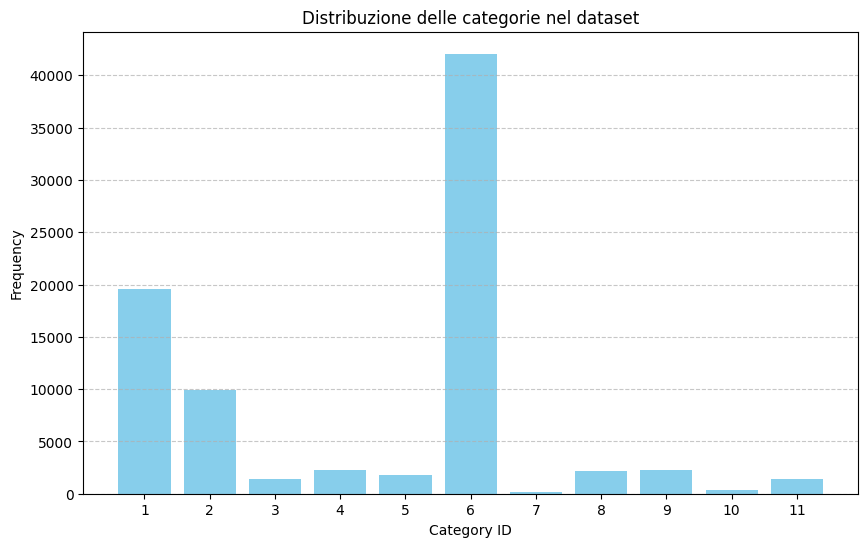

In [29]:
plot_category_distribution(new_coco_json_path)

FINAL JSON


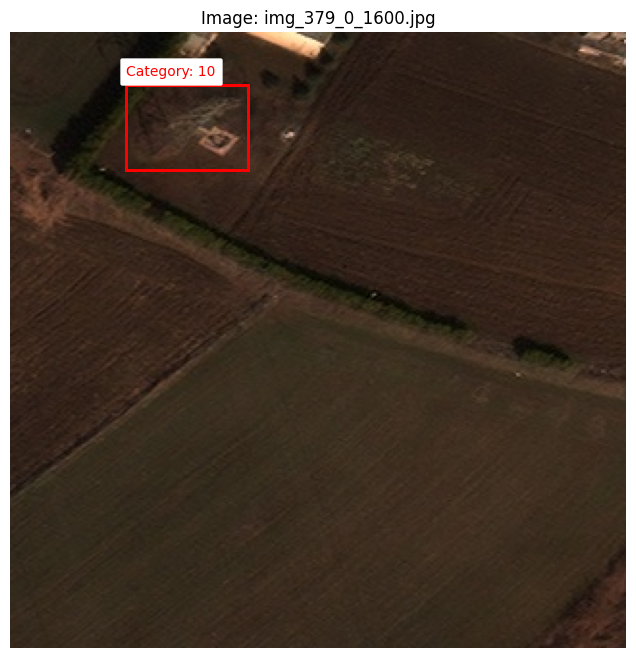

In [30]:
print("FINAL JSON")
display_images_with_bboxes(new_coco_json_path, random_filename(new_coco_json_path), img_dict)

# Splitting

In [31]:
def split_coco_and_check(coco_file, output_path, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1): #modifica in modo da fare lo split solo train e test
    # Carica il file COCO
    with open(coco_file, 'r') as f:
        coco_data = json.load(f)

    images = coco_data['images']
    annotations = coco_data['annotations']
    categories = coco_data['categories']

    total_images = len(images)
    total_annotations = len(annotations)

    # Shuffle delle immagini per garantire casualità
    random.shuffle(images)

    # Calcola i numeri di immagini per train, val e test
    train_count = int(train_ratio * total_images)
    val_count = int(val_ratio * total_images)
    test_count = total_images - train_count - val_count

    train_images = images[:train_count]
    val_images = images[train_count:train_count + val_count]
    test_images = images[train_count + val_count:]

    # Crea set di ID immagini
    train_ids = {img['id'] for img in train_images}
    val_ids = {img['id'] for img in val_images}
    test_ids = {img['id'] for img in test_images}

    # Divide le annotazioni
    train_annotations = [ann for ann in annotations if ann['image_id'] in train_ids]
    val_annotations = [ann for ann in annotations if ann['image_id'] in val_ids]
    test_annotations = [ann for ann in annotations if ann['image_id'] in test_ids]

    train_bbox_count = len(train_annotations)
    val_bbox_count = len(val_annotations)
    test_bbox_count = len(test_annotations)

    # Salva i file di output
    def save_split(file_name, images_split):
        with open(file_name, 'w') as f:
            for img in images_split:
                f.write(f"{output_path}/{img['file_name']}\n")

    save_split('train.txt', train_images)
    save_split('val.txt', val_images)
    save_split('test.txt', test_images)

    # Controlla le proporzioni
    check_split_proportions(
        total_images, total_annotations,
        len(train_images), len(val_images), len(test_images),
        train_bbox_count, val_bbox_count, test_bbox_count,
        train_ratio, val_ratio, test_ratio,
        train_annotations, val_annotations, test_annotations,
        categories
    )

def check_split_proportions(total_images, total_annotations, train_count, val_count, test_count, 
                            train_bbox_count, val_bbox_count, test_bbox_count, 
                            train_ratio, val_ratio, test_ratio, 
                            train_annotations, val_annotations, test_annotations, categories):
    # Percentuali per immagini
    train_image_percentage = (train_count / total_images) * 100
    val_image_percentage = (val_count / total_images) * 100
    test_image_percentage = (test_count / total_images) * 100

    # Percentuali per bbox
    train_bbox_percentage = (train_bbox_count / total_annotations) * 100
    val_bbox_percentage = (val_bbox_count / total_annotations) * 100
    test_bbox_percentage = (test_bbox_count / total_annotations) * 100

    print(f"Totale immagini: {total_images}")
    print(f"Totale annotazioni (bbox): {total_annotations}")
    print(f"Train: {train_count} immagini ({train_image_percentage:.2f}%) ({train_bbox_count} bbox) ({train_bbox_percentage:.2f}%)")
    print(f"Val: {val_count} immagini ({val_image_percentage:.2f}%) ({val_bbox_count} bbox) ({val_bbox_percentage:.2f}%)")
    print(f"Test: {test_count} immagini ({test_image_percentage:.2f}%) ({test_bbox_count} bbox) ({test_bbox_percentage:.2f}%)")

    # Calcola il numero di annotazioni per categoria nei vari set
    category_count_train = defaultdict(int)
    category_count_val = defaultdict(int)
    category_count_test = defaultdict(int)

    for annotation in train_annotations:
        category_count_train[annotation['category_id']] += 1
    for annotation in val_annotations:
        category_count_val[annotation['category_id']] += 1
    for annotation in test_annotations:
        category_count_test[annotation['category_id']] += 1

    # Stampa le proporzioni per categoria
    print("\nProporzioni per categoria:")
    for category in categories:
        category_id = category['id']
        category_name = category['name']

        # Conta il numero di annotazioni per categoria in ogni set
        train_cat_count = category_count_train.get(category_id, 0)
        val_cat_count = category_count_val.get(category_id, 0)
        test_cat_count = category_count_test.get(category_id, 0)

        # Calcola la percentuale di annotazioni per categoria
        total_cat_annotations = train_cat_count + val_cat_count + test_cat_count
        if total_cat_annotations > 0:
            train_cat_percentage = (train_cat_count / total_cat_annotations) * 100
            val_cat_percentage = (val_cat_count / total_cat_annotations) * 100
            test_cat_percentage = (test_cat_count / total_cat_annotations) * 100
        else:
            train_cat_percentage = val_cat_percentage = test_cat_percentage = 0.0

        print(f"{category_name}:")
        print(f"  Train: {train_cat_count} annotazioni ({train_cat_percentage:.2f}%)")
        print(f"  Val: {val_cat_count} annotazioni ({val_cat_percentage:.2f}%)")
        print(f"  Test: {test_cat_count} annotazioni ({test_cat_percentage:.2f}%)")

In [32]:
split_coco_and_check(new_coco_json_path, img_dict, train_ratio=0.6, val_ratio=0.3, test_ratio=0.1)

Totale immagini: 19301
Totale annotazioni (bbox): 83391
Train: 11580 immagini (60.00%) (50721 bbox) (60.82%)
Val: 5790 immagini (30.00%) (23780 bbox) (28.52%)
Test: 1931 immagini (10.00%) (8890 bbox) (10.66%)

Proporzioni per categoria:
Aircraft:
  Train: 860 annotazioni (59.93%)
  Val: 438 annotazioni (30.52%)
  Test: 137 annotazioni (9.55%)
Passenger Vehicle:
  Train: 12023 annotazioni (61.29%)
  Val: 5406 annotazioni (27.56%)
  Test: 2186 annotazioni (11.14%)
Truck:
  Train: 5988 annotazioni (60.48%)
  Val: 2918 annotazioni (29.47%)
  Test: 994 annotazioni (10.04%)
Railway Vehicle:
  Train: 966 annotazioni (66.90%)
  Val: 339 annotazioni (23.48%)
  Test: 139 annotazioni (9.63%)
Maritime Vessel:
  Train: 1367 annotazioni (61.30%)
  Val: 591 annotazioni (26.50%)
  Test: 272 annotazioni (12.20%)
Engineering Vehicle:
  Train: 1089 annotazioni (61.66%)
  Val: 503 annotazioni (28.48%)
  Test: 174 annotazioni (9.85%)
Building:
  Train: 25445 annotazioni (60.49%)
  Val: 12176 annotazioni (2

# Dataset Preprocessing

In [33]:
def parse_coco_annotation(annotation_data):
    """
    Converti le annotazioni COCO in una struttura utile.
    """
    boxes = []
    labels = []

    for ann in annotation_data:
        category_id = ann['category_id']  # Usa direttamente il category_id come etichetta
        bbox = ann['bbox']  # I bounding box sono già nel formato [xmin, ymin, xmax, ymax]
        xmin, ymin, xmax, ymax = bbox

        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(category_id)

    return {'boxes': boxes, 'labels': labels}

def create_coco_data_lists(coco_file, splits_path, output_folder):
    """
    Converte i dati COCO e split in liste per train, val e test.
    """
    with open(coco_file, 'r') as f:
        coco_data = json.load(f)

    # Prepara mappature da immagini e annotazioni
    images = {img['file_name']: img for img in coco_data['images']}  # Mappa file_name -> immagine
    annotations_by_image = defaultdict(list)
    for ann in coco_data['annotations']:
        annotations_by_image[ann['image_id']].append(ann)

    # Genera i dati per ciascuno split
    for split in ['train', 'val', 'test']:
        split_file = os.path.join(splits_path, f"{split}.txt")
        with open(split_file, 'r') as f:
            image_files = [line.strip() for line in f.readlines()]

        image_list = []
        objects_list = []

        for image_file in image_files:
            file_name = os.path.basename(image_file)  # Ottieni solo il nome del file
            if file_name not in images:
                continue

            image_info = images[file_name]
            image_id = image_info['id']
            annotations = annotations_by_image[image_id]
            objects = parse_coco_annotation(annotations)

            if not objects['boxes']:
                continue

            image_list.append(image_file)
            objects_list.append(objects)

        # Salva i risultati
        with open(os.path.join(output_folder, f"{split.upper()}_images.json"), 'w') as j:
            json.dump(image_list, j)
        with open(os.path.join(output_folder, f"{split.upper()}_objects.json"), 'w') as j:
            json.dump(objects_list, j)

In [34]:
create_coco_data_lists(new_coco_json_path, out_dataset_pth, out_dataset_pth)

## Dataloader

In [35]:
class CustomDataset(Dataset):
    """
    A PyTorch Dataset class to be used in a DataLoader for batching.
    """

    def __init__(self, path_image, path_bbox):
        """
        :param path_image: Path to the JSON file containing image paths.
        :param path_bbox: Path to the JSON file containing bounding boxes and labels.
        """
        # Load data
        with open(path_image, 'r') as j:
            self.images = json.load(j)
        with open(path_bbox, 'r') as j:
            self.objects = json.load(j)

        # Ensure the lengths match
        assert len(self.images) == len(self.objects), "Images and annotations must have the same length."

    def __transform(self, image, boxes, labels):
        """
        Apply transformations to the image, boxes, and labels.
        :param image: A PIL Image.
        :param boxes: Bounding boxes as a tensor of dimensions (n_objects, 4).
        :param labels: Labels as a tensor of dimensions (n_objects).
        :return: Transformed image, boxes, and labels.
        """
        def resize(image, boxes, dims=(300, 300)):
            # Resize image
            new_image = FT.resize(image, dims)

            # Normalize bounding boxes
            old_dims = torch.FloatTensor([image.width, image.height, image.width, image.height]).unsqueeze(0)
            new_boxes = boxes / old_dims  # Percent coordinates
            #new_dims = torch.FloatTensor([dims[0], dims[1], dims[0], dims[1]]).unsqueeze(0)
            #new_boxes = new_boxes * new_dims

            return new_image, new_boxes

        # ImageNet normalization values
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]

        # Resize image and normalize boxes
        image, boxes = resize(image, boxes)

        # Convert image to tensor
        image = FT.to_tensor(image)

        # Normalize image
        image = FT.normalize(image, mean=mean, std=std)

        return image, boxes, labels

    def __getitem__(self, idx):
        """
        Retrieve an image and its corresponding objects.
        :param idx: Index of the data point.
        :return: Transformed image, bounding boxes, and labels.
        """
        # Load image
        image = Image.open(self.images[idx]).convert('RGB')

        # Load objects
        objects = self.objects[idx]
        boxes = torch.FloatTensor(objects['boxes'])  # (n_objects, 4)
        labels = torch.LongTensor(objects['labels'])  # (n_objects)

        # Apply transformations
        image, boxes, labels = self.__transform(image, boxes, labels)

        return image, boxes, labels

    def __len__(self):
        """
        Total number of data points.
        :return: Length of the dataset.
        """
        return len(self.images)

    def collate_fn(self, batch):
        """
        Since each image may have a different number of objects, we need a collate function (to be passed to the DataLoader).

        This describes how to combine these tensors of different sizes. We use lists.

        :param batch: an iterable of N sets from __getitem__()
        :return: a tensor of images, lists of varying-size tensors of bounding boxes, labels.
        """

        images = list()
        boxes = list()
        labels = list()

        for b in batch:
            images.append(b[0])
            boxes.append(b[1])
            labels.append(b[2])

        images = torch.stack(images, dim=0)

        return images, boxes, labels  # tensor (N, 3, 300, 300), 2 lists of N tensors each

In [36]:
train_dataset = CustomDataset(train_image, train_bbox)
val_dataset = CustomDataset(val_image, val_bbox)
test_dataset = CustomDataset(test_image, test_bbox)

In [37]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=train_dataset.collate_fn, num_workers=3, pin_memory=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=train_dataset.collate_fn, num_workers=3, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=train_dataset.collate_fn, num_workers=3, pin_memory=True)

## Model (Import [GitHub](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/model.py))

In [38]:
# Aggiungi la directory che contiene 'model.py' alla variabile sys.path
sys.path.append(model_ssd_path)

# Ora importa il modulo 'model' che si trova nella stessa cartella
from model import *  

/kaggle/input/ssd_checkpoint/pytorch/ssd/3/utils.py:570: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if d.__name__ is 'adjust_hue':


### Checkpoint

In [39]:
# Carica il checkpoint
checkpoint = torch.load(checkpoint_path, map_location='cpu')

# Verifica che la variabile 'checkpoint' contenga i dati corretti
print(checkpoint.keys())

/tmp/ipykernel_23/253858645.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cpu')
/opt/conda/lib/python3.10/site-p

dict_keys(['epoch', 'model'])


In [40]:
# Crea un'istanza del modello
num_classses = 12

model = SSD300(num_classses) 

# Carica i pesi pre-addestrati per il backbone e altre componenti comuni
pretrained_dict = checkpoint['model'].state_dict()

# Ottieni i pesi del modello
model_dict = model.state_dict()

# Mantieni solo i pesi che corrispondono tra il modello pre-addestrato e il nuovo
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and v.size() == model_dict[k].size()}
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)

# Inizializza i pesi dei nuovi layer di classificazione
def initialize_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# Applica l'inizializzazione solo ai layer di classificazione
model.pred_convs.apply(initialize_weights)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 218MB/s]  



Loaded base model.



PredictionConvolutions(
  (loc_conv4_3): Conv2d(512, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (loc_conv7): Conv2d(1024, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (loc_conv8_2): Conv2d(512, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (loc_conv9_2): Conv2d(256, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (loc_conv10_2): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (loc_conv11_2): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cl_conv4_3): Conv2d(512, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cl_conv7): Conv2d(1024, 72, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cl_conv8_2): Conv2d(512, 72, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cl_conv9_2): Conv2d(256, 72, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cl_conv10_2): Conv2d(256, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cl_conv11_2): Conv2d(256, 48, kernel_size=(3, 3), str

# Training

In [41]:
def find_intersection(set_1, set_2):
    """
    Find the intersection of every box combination between two sets of boxes that are in boundary coordinates.

    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: intersection of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # PyTorch auto-broadcasts singleton dimensions
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  # (n1, n2, 2)
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))  # (n1, n2, 2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  # (n1, n2, 2)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]  # (n1, n2)


def find_jaccard_overlap(set_1, set_2):
    """
    Find the Jaccard Overlap (IoU) of every box combination between two sets of boxes that are in boundary coordinates.

    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: Jaccard Overlap of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # Find intersections
    intersection = find_intersection(set_1, set_2)  # (n1, n2)

    # Find areas of each box in both sets
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])  # (n1)
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])  # (n2)

    # Find the union
    # PyTorch auto-broadcasts singleton dimensions
    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection  # (n1, n2)

    return intersection / union  # (n1, n2)

In [42]:
class Trainer:
    def __init__(self, model, train_dataset, train_dataloader, criterion, optimizer, batch_size, num_workers, device, 
                 grad_clip=None, print_freq=10, decay_lr_at=None, decay_lr_to=0.1, 
                 momentum=0.9, weight_decay=5e-4, epochs=50):  
        """
        Initialize the Trainer.
        
        :param model: SSD300 model instance
        :param train_dataset: Dataset object
        :param criterion: Loss function
        :param optimizer: Optimizer
        :param batch_size: Training batch size
        :param num_workers: Number of data loading workers
        :param device: Device to use for training ('cuda' or 'cpu')
        :param grad_clip: Gradient clipping value (default: None)
        :param print_freq: Frequency of printing training progress
        :param decay_lr_at: Iterations to decay learning rate
        :param decay_lr_to: Learning rate decay factor
        :param momentum: Momentum for optimizer
        :param weight_decay: Weight decay for optimizer
        :param epochs: Number of epochs (now a parameter)
        """
        self.model = model
        self.train_dataset = train_dataset
        self.criterion = criterion
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.device = device
        self.grad_clip = grad_clip
        self.print_freq = print_freq
        self.decay_lr_at = decay_lr_at if decay_lr_at is not None else [80000, 100000]
        self.decay_lr_to = decay_lr_to
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.epochs = epochs  # Usando il parametro 'epochs'

        # Prepare dataloader
        self.train_loader = train_dataloader

        # Calcola le epoche di decadimento
        self.decay_epochs = [it // (len(train_dataset) // self.batch_size) for it in self.decay_lr_at]

    def adjust_learning_rate(self, epoch):
        """
        Adjust the learning rate at specific epochs.
        """
        if epoch in self.decay_epochs:
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = param_group['lr'] * self.decay_lr_to
            print(f"Learning rate adjusted to {param_group['lr']} at epoch {epoch}")

    def train_one_epoch(self, epoch):
        """
        Perform one epoch of training.
        """
        self.model.train()
        batch_time = AverageMeter()
        data_time = AverageMeter()
        losses = AverageMeter()
    
        start = time.time()
    
        with tqdm(total=len(self.train_loader), desc=f"Epoch {epoch}/{self.epochs}", unit="batch") as pbar:
            for i, (images, boxes, labels) in enumerate(self.train_loader):
                data_time.update(time.time() - start)
    
                # Move to device
                images = images.to(self.device)
                boxes = [b.to(self.device) for b in boxes]
                labels = [l.to(self.device) for l in labels]
    
                # Validation: Check if all box coordinates are valid
                for box in boxes:
                    assert torch.all(box >= 0), "Box coordinates must be non-negative"
                    assert torch.all(box[:, 2:] > box[:, :2]), "Box dimensions must be positive"
    
                # Forward pass
                predicted_locs, predicted_scores = self.model(images)
    
                # Compute loss
                loss = self.criterion(predicted_locs, predicted_scores, boxes, labels)
    
                # Backward pass
                self.optimizer.zero_grad()
                with torch.autograd.detect_anomaly():
                    loss.backward()
    
                # Gradient clipping
                if self.grad_clip is not None:
                    clip_gradient(self.optimizer, self.grad_clip)
    
                # Update model parameters
                self.optimizer.step()
    
                # Update metrics
                losses.update(loss.item(), images.size(0))
                batch_time.update(time.time() - start)
    
                # Update progress bar
                pbar.set_postfix({
                    "Batch Time": f"{batch_time.val:.3f}s",
                    "Loss": f"{losses.val:.4f} (avg: {losses.avg:.4f})"
                })
                pbar.update(1)
    
                start = time.time()
    
        del predicted_locs, predicted_scores, images, boxes, labels


    def save_checkpoint(self, epoch):
        """
        Save model checkpoint.
        """
        torch.save({
            'epoch': epoch,
            'model': self.model,
            'optimizer': self.optimizer,
        }, f'checkpoint_epoch_{epoch}.pth')
        print(f"Checkpoint saved for epoch {epoch}.")

    def train(self, start_epoch=0):
        """
        Train the model across all epochs.
        """
        for epoch in range(start_epoch, self.epochs):
            self.adjust_learning_rate(epoch)
            self.train_one_epoch(epoch)
            self.save_checkpoint(epoch)
            """
        Perform one epoch of training.
        """
        self.model.train()
        batch_time = AverageMeter()
        data_time = AverageMeter()
        losses = AverageMeter()

        start = time.time()

        with tqdm(total=len(self.train_loader), desc=f"Epoch {epoch}/{self.epochs}", unit="batch") as pbar:
            for i, (images, boxes, labels) in enumerate(self.train_loader):
                data_time.update(time.time() - start)

                # Move to device
                images = images.to(self.device)
                boxes = [b.to(self.device) for b in boxes]
                labels = [l.to(self.device) for l in labels]

                # Forward pass
                predicted_locs, predicted_scores = self.model(images)

                # Compute loss
                loss = self.criterion(predicted_locs, predicted_scores, boxes, labels)

                # Backward pass
                self.optimizer.zero_grad()
                loss.backward()

                # Gradient clipping
                if self.grad_clip is not None:
                    clip_gradient(self.optimizer, self.grad_clip)

                # Update model parameters
                self.optimizer.step()

                # Update metrics
                losses.update(loss.item(), images.size(0))
                batch_time.update(time.time() - start)

                # Update progress bar
                pbar.set_postfix({
                    "Batch Time": f"{batch_time.val:.3f}s",
                    "Loss": f"{losses.val:.4f} (avg: {losses.avg:.4f})"
                })
                pbar.update(1)

                start = time.time()

        del predicted_locs, predicted_scores, images, boxes, labels

In [43]:
class MultiBoxLoss(nn.Module):
    """
    The MultiBox loss, a loss function for object detection.

    This is a combination of:
    (1) a localization loss for the predicted locations of the boxes, and
    (2) a confidence loss for the predicted class scores.
    """
    def __init__(self, priors_cxcy, threshold=0.5, neg_pos_ratio=3, alpha=1.):
        super(MultiBoxLoss, self).__init__()
        self.priors_cxcy = priors_cxcy
        self.priors_xy = cxcy_to_xy(priors_cxcy)
        self.threshold = threshold
        self.neg_pos_ratio = neg_pos_ratio
        self.alpha = alpha

        self.smooth_l1 = nn.SmoothL1Loss()
        self.cross_entropy = nn.CrossEntropyLoss(reduction='none')

    def forward(self, predicted_locs, predicted_scores, boxes, labels):
        """
        Forward propagation.
    
        :param predicted_locs: predicted locations/boxes w.r.t the 8732 prior boxes, a tensor of dimensions (N, 8732, 4)
        :param predicted_scores: class scores for each of the encoded locations/boxes, a tensor of dimensions (N, 8732, n_classes)
        :param boxes: true  object bounding boxes in boundary coordinates, a list of N tensors
        :param labels: true object labels, a list of N tensors
        :return: multibox loss, a scalar
        """
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        n_classes = predicted_scores.size(2)

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        true_locs = torch.zeros((batch_size, n_priors, 4), dtype=torch.float).to(device)
        true_classes = torch.zeros((batch_size, n_priors), dtype=torch.long).to(device)

        for i in range(batch_size):
            n_objects = boxes[i].size(0)

            overlap = find_jaccard_overlap(boxes[i], self.priors_xy)

            overlap_for_each_prior, object_for_each_prior = overlap.max(dim=0)

            _, prior_for_each_object = overlap.max(dim=1)
            object_for_each_prior[prior_for_each_object] = torch.LongTensor(range(n_objects)).to(device)
            overlap_for_each_prior[prior_for_each_object] = 1.

            label_for_each_prior = labels[i][object_for_each_prior]
            label_for_each_prior[overlap_for_each_prior < self.threshold] = 0

            true_classes[i] = label_for_each_prior
            true_locs[i] = cxcy_to_gcxgcy(xy_to_cxcy(boxes[i][object_for_each_prior]), self.priors_cxcy)

        positive_priors = true_classes != 0

        loc_loss = self.smooth_l1(predicted_locs[positive_priors], true_locs[positive_priors])

        n_positives = positive_priors.sum(dim=1)
        #n_hard_negatives = self.neg_pos_ratio * n_positives
        n_hard_negatives = torch.clamp(self.neg_pos_ratio * n_positives, max=n_priors)


        conf_loss_all = self.cross_entropy(predicted_scores.view(-1, n_classes), true_classes.view(-1))
        conf_loss_all = conf_loss_all.view(batch_size, n_priors)

        conf_loss_pos = conf_loss_all[positive_priors]

        conf_loss_neg = conf_loss_all.clone()
        conf_loss_neg[positive_priors] = 0.
        conf_loss_neg, _ = conf_loss_neg.sort(dim=1, descending=True)
        hardness_ranks = torch.LongTensor(range(n_priors)).unsqueeze(0).expand_as(conf_loss_neg).to(device)
        hard_negatives = hardness_ranks < n_hard_negatives.unsqueeze(1)
        conf_loss_hard_neg = conf_loss_neg[hard_negatives]

        total_positives = n_positives.sum().float()
        if total_positives == 0:
            total_positives = 1.0  # Evita divisioni per zero

        conf_loss = (conf_loss_hard_neg.sum() + conf_loss_pos.sum()) / n_positives.sum().float()

        return conf_loss + self.alpha * loc_loss

In [44]:
def clip_gradient(optimizer, grad_clip):
    """
    Clips gradients computed during backpropagation to avoid explosion of gradients.

    :param optimizer: optimizer with the gradients to be clipped
    :param grad_clip: clip value
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)


In [45]:
# Model parameters
n_classes = 12  # number of different types of objects

# Hyperparameters
batch_size = 8  # batch size
workers = 8  # number of workers for loading data in the DataLoader
epochs = 50
lr = 1e-3  # learning rate
momentum = 0.9  # momentum
weight_decay = 1e-3  # weight decay
grad_clip = 0.5  # clip if gradients are exploding, which may happen at larger batch sizes (sometimes at 32) - you will recognize it by a sorting error in the MuliBox loss calculation

In [46]:
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device)

# Ottimizzatore
biases = [param for name, param in model.named_parameters() if param.requires_grad and name.endswith('.bias')]
not_biases = [param for name, param in model.named_parameters() if param.requires_grad and not name.endswith('.bias')]
optimizer = torch.optim.SGD(params=[{'params': biases, 'lr': 2 * lr}, {'params': not_biases}],
                            lr=lr, momentum=momentum, weight_decay=weight_decay)

In [47]:
# Configurazione del dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on {device}")

# Preparazione del modello, dataset e dataloader
model = model.to(device)  # Sposta il modello sul dispositivo

Training on cuda


In [49]:
# Creazione del Trainer
trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    train_dataloader=train_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    batch_size=batch_size,
    num_workers=workers,
    device=device,
    grad_clip=grad_clip,
    epochs=epochs  
)

# Avvio del training
trainer.train()

Epoch 0/50:   3%|▎         | 31/1223 [00:11<07:13,  2.75batch/s, Batch Time=0.343s, Loss=0.2350 (avg: 0.6957)]


KeyboardInterrupt: 

# Testing

In [50]:
# Carica il checkpoint
'''
AGGIORNARE CHECKPOINT PER TESTING
'''
checkpoint_path = "/kaggle/working/checkpoint_epoch_38.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)

# Carica il modello completo dal checkpoint
model = checkpoint['model'].to(device)

# Metti il modello in modalità di valutazione
model.eval()

/tmp/ipykernel_23/1083670527.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


SSD300(
  (base): VGGBase(
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), 

In [51]:
def evaluate(model, test_loader, device, n_classes=12):
    """
    Perform evaluation and compute Precision, Recall, and Average Precision (AP) for each class.
    
    :param model: Trained SSD model to be evaluated
    :param test_loader: DataLoader for the test dataset
    :param device: Device to use for evaluation ('cuda' or 'cpu')
    """
    model.eval()

    det_boxes, det_labels, det_scores = [], [], []
    true_boxes, true_labels = [], []
    all_preds, all_targets = [], []  # For confusion matrix

    with torch.no_grad():
        for images, boxes, labels in tqdm(test_loader, desc='Evaluating DataLoader'):
            images = images.to(device)  # Move images to device
            
            # Forward pass
            predicted_locs, predicted_scores = model(images)
            
            # Detect objects for each image in the batch
            batch_det_boxes, batch_det_labels, batch_det_scores = model.detect_objects(
                predicted_locs, predicted_scores,
                min_score=0.01, max_overlap=0.45, top_k=200
            )

            # Append predictions and ground truths
            det_boxes.extend(batch_det_boxes)
            det_labels.extend(batch_det_labels)
            det_scores.extend(batch_det_scores)
            true_boxes.extend(boxes)
            true_labels.extend(labels)

            # Store predictions and targets for confusion matrix
            all_preds.extend(batch_det_labels)
            all_targets.extend(labels)

    average_precisions = torch.zeros(n_classes - 1, dtype=torch.float).to(device)
    precisions_per_class = torch.zeros(n_classes - 1, dtype=torch.float).to(device)
    recalls_per_class = torch.zeros(n_classes - 1, dtype=torch.float).to(device)

    print("\n--- Calcolo delle Metriche per Classe ---")
    for c in tqdm(range(1, n_classes), desc="Computing metrics for each class"):
        # Filter detections and ground truths for the current class
        det_class_boxes = [
            torch.tensor(boxes, dtype=torch.float32).to(device)
            for boxes, labels in zip(det_boxes, det_labels) if c in labels
        ]
        det_class_scores = [
            torch.tensor(scores, dtype=torch.float32).to(device)
            for scores, labels in zip(det_scores, det_labels) if c in labels
        ]
        true_class_boxes = [
            torch.tensor(boxes, dtype=torch.float32).to(device)
            for boxes, labels in zip(true_boxes, true_labels) if c in labels
        ]

        # Flatten lists of tensors
        det_class_boxes = torch.cat(det_class_boxes, dim=0) if det_class_boxes else torch.empty((0, 4)).to(device)
        det_class_scores = torch.cat(det_class_scores, dim=0) if det_class_scores else torch.empty(0).to(device)
        true_class_boxes = torch.cat(true_class_boxes, dim=0) if true_class_boxes else torch.empty((0, 4)).to(device)

        n_easy_class_objects = true_class_boxes.size(0)
        n_class_detections = det_class_boxes.size(0)

        if n_class_detections == 0:
            continue

        det_class_scores, sort_ind = torch.sort(det_class_scores, descending=True)
        det_class_boxes = det_class_boxes[sort_ind]

        true_positives = torch.zeros(n_class_detections, dtype=torch.float).to(device)
        false_positives = torch.zeros(n_class_detections, dtype=torch.float).to(device)

        true_class_boxes_detected = torch.zeros(n_easy_class_objects, dtype=torch.uint8).to(device)

        for d in range(n_class_detections):
            this_detection_box = det_class_boxes[d].unsqueeze(0)

            # Compute IoU with true boxes
            overlaps = find_jaccard_overlap(this_detection_box, true_class_boxes)
            max_overlap, ind = torch.max(overlaps.squeeze(0), dim=0)

            if max_overlap.item() > 0.5:
                if true_class_boxes_detected[ind] == 0:
                    true_positives[d] = 1
                    true_class_boxes_detected[ind] = 1
                else:
                    false_positives[d] = 1
            else:
                false_positives[d] = 1

        cumul_true_positives = torch.cumsum(true_positives, dim=0)
        cumul_false_positives = torch.cumsum(false_positives, dim=0)
        cumul_precision = cumul_true_positives / (cumul_true_positives + cumul_false_positives + 1e-10)
        cumul_recall = cumul_true_positives / n_easy_class_objects

        # Average Precision
        recall_thresholds = torch.arange(0, 1.1, 0.1).tolist()
        precisions = torch.zeros(len(recall_thresholds), dtype=torch.float).to(device)

        for i, t in enumerate(recall_thresholds):
            recalls_above_t = cumul_recall >= t
            if recalls_above_t.any():
                precisions[i] = cumul_precision[recalls_above_t].max()
            else:
                precisions[i] = 0.

        average_precisions[c - 1] = precisions.mean()

        # Precision and Recall for the current class
        precisions_per_class[c - 1] = cumul_precision[-1] if cumul_precision.numel() > 0 else 0.0
        recalls_per_class[c - 1] = cumul_recall[-1] if cumul_recall.numel() > 0 else 0.0

    # Print results
    print("\n--- Performance Metrics per Classe ---")
    print("{:<20} {:<15} {:<15} {:<15}".format('Classe', 'Precision', 'Recall', 'Average Precision'))
    for c in range(1, n_classes):  # Skip background class (0)
        print("{:<20} {:<15.4f} {:<15.4f} {:<15.4f}".format(
            f"Classe {c}", precisions_per_class[c - 1], recalls_per_class[c - 1], average_precisions[c - 1]
        ))

    # Overall Metrics
    print("\n--- Metriche Complessive ---")
    print(f"Precision media: {precisions_per_class.mean().item():.4f}")
    print(f"Recall media: {recalls_per_class.mean().item():.4f}")
    print(f"AP media: {average_precisions.mean().item():.4f}")

    return all_preds, all_targets

In [52]:
def plot_confusion_matrix(all_preds, all_targets):
    """
    Calcola e visualizza la confusion matrix normalizzata.

    Args:
        all_preds (list): Lista di tensori delle previsioni.
        all_targets (list): Lista di tensori dei target reali.
    """
    pred_labels = []
    true_labels = []

    for pred, target in zip(all_preds, all_targets):
        # Aggiungi tutte le etichette previste e reali
        pred_labels.extend(pred.cpu().numpy() if isinstance(pred, torch.Tensor) else np.array(pred))
        true_labels.extend(target.cpu().numpy() if isinstance(target, torch.Tensor) else np.array(target))

    # Assicurati che il numero di previsioni e target sia coerente
    if len(pred_labels) != len(true_labels):
        min_len = min(len(pred_labels), len(true_labels))
        pred_labels = pred_labels[:min_len]
        true_labels = true_labels[:min_len]

    # Calcola e visualizza la matrice di confusione
    cm = confusion_matrix(true_labels, pred_labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalizza per riga

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, cmap='Blues', fmt='.2f', 
                xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [53]:
# Esegui l'evaluazione e ottieni anche i dati per la confusion matrix
all_preds, all_targets = evaluate(model, test_dataloader, device)

Evaluating DataLoader: 100%|██████████| 1619/1619 [00:37<00:00, 42.86it/s]



--- Calcolo delle Metriche per Classe ---


Computing metrics for each class: 100%|██████████| 11/11 [00:48<00:00,  4.38s/it]


--- Performance Metrics per Classe ---
Classe               Precision       Recall          Average Precision
Classe 1             0.0977          0.9186          0.4298         
Classe 2             0.0132          0.7712          0.2886         
Classe 3             0.0163          0.4533          0.1411         
Classe 4             0.0121          0.5794          0.2215         
Classe 5             0.0139          0.6706          0.2789         
Classe 6             0.0950          0.9174          0.4368         
Classe 7             0.0204          0.7500          0.2779         
Classe 8             0.0182          0.4229          0.2227         
Classe 9             0.0126          0.5979          0.3236         
Classe 10            0.0195          0.8571          0.5802         
Classe 11            0.0213          0.6250          0.3816         

--- Metriche Complessive ---
Precision media: 0.0309
Recall media: 0.6876
AP media: 0.3257


/tmp/ipykernel_23/1396213051.py:25: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalizza per riga


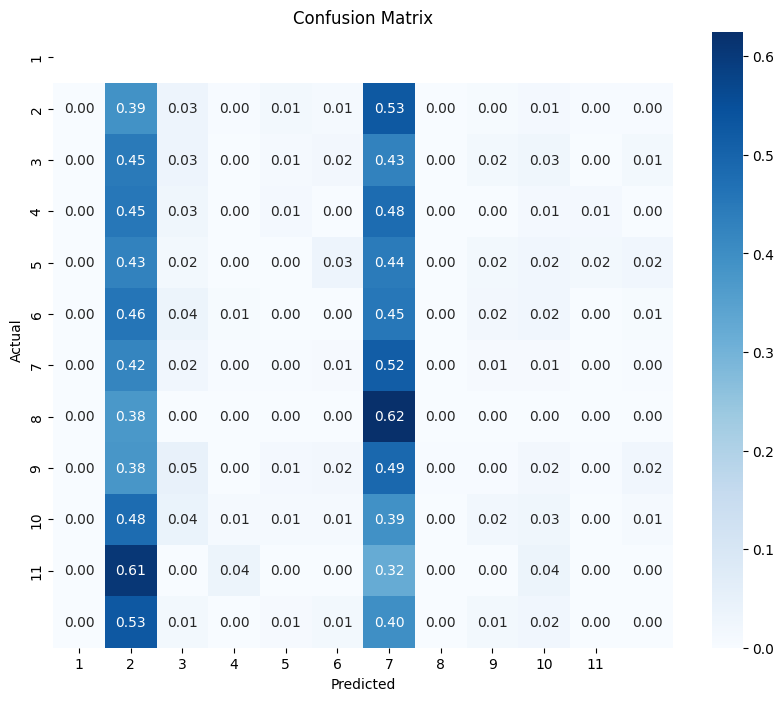

In [54]:
plot_confusion_matrix(all_preds, all_targets)